In [1]:
import sys
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3 as sql

import folium

In [2]:
conn = sql.connect("dataset/database.sqlite")

In [27]:
df = pd.read_sql_query("select * from business", conn)
df = df.dropna(subset=['latitude', 'longitude'])
df.head()

,id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open
0,--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.8409,-79.3996,3.0,30,1
1,--7zmmkVg-IMGaXbuVd0SQ,Primal Brewery,,16432 Old Statesville Rd,Huntersville,NC,28078,35.4371,-80.8437,4.0,42,1
2,--8LPVSo5i0Oo61X01sV9A,Valley Bone and Joint Specialists,,"3941 E Baseline Rd, Ste 102",Gilbert,AZ,85234,33.3795,-111.7280,4.5,3,1
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,The Strip,3355 Las Vegas Blvd S,Las Vegas,NV,89109,36.1232,-115.1690,4.0,1389,1
4,--9QQLMTbFzLJ_oT-ON3Xw,Great Clips,,"1835 E Guadalupe Rd, Ste 106",Tempe,AZ,85283,33.3617,-111.9100,3.0,9,1


In [28]:
print("Unique states:", df.state.unique())
print("Number of unique states:", len(df.state.unique()))

Unique states: ['ON' 'NC' 'AZ' 'NV' 'PA' 'OH' 'EDH' 'BW' 'IL' 'WI' 'QC' 'SC' 'MLN' 'ELN'
 'WLN' 'NI' 'C' 'HLD' 'NY' 'FIF' 'NYK' 'ST' 'ESX' '01' 'SCB' 'BY' 'WHT'
 'WA' 'CA' 'XGL' 'NTH' 'GLG' 'STG' 'AL' '3' 'FLN' 'ABE' 'PKN' 'NLK' 'DE'
 'NE' 'ZET' 'HH' '75' 'TAM' 'FL' 'VT' 'FAL' 'SL' 'KHL' 'RCC']
Number of unique states: 51


In [29]:
lats_longs = list(zip(list(df.latitude), list(df.longitude)))

In [30]:
df.shape

(156638, 12)

In [31]:
m = folium.Map(location=[39.495834, -96.475316], zoom_start=1)
for i, (lat, long) in list(enumerate(lats_longs))[:500]: # Only for first 500
    folium.Marker([lat, long]).add_to(m)
    if i % 1000 == 0:
        print(i)

0


In [32]:
m

From our map, it looks like we have the following greater metropolitan areas:
1. Las Vegas, NV
2. Phoenix, AZ
3. Champaign, IL
4. Madison, WI
5. Cleveland, OH
6. Pittsburgh, PA
7. Toronto, Canada
8. Montreal, Canada
9. Charlotte, NC
10. Stuttgart, Germany
11. Edinburgh, Scotland

#### I'm Missing a City!!! Time to go find it :D 

### What we're going to do
0. Find latitude/longitude for each city (by hand...ugh)
1. For each data point, add it to its closest known city.
2. For each city, create a vector of distances from the center of the city to that business
3. For the grouping with the largest average distance (or std), plot the points with the greatest distance and the shortest distance. My guess is that those furthest points will really be a different city

In [33]:
city_lat_long_dict = {
    'las_vegas' : (36.1699, -115.1398),
    'phoenix' : (33.4484, -112.0740),
    'champaign' : (40.1164, -88.2434),
    'madison' : (43.0731, -89.4012),
    'cleveland' : (41.4993, -81.6944),
    'pittsburgh' : (40.4406, -79.9959),
    'toronto' : (43.6532, -79.3832),
    'montreal' : (45.5017, -73.5673),
    'charlotte' : (35.2271, -80.8431),
    'stuttgart' : (48.7758, 9.1829),
    'endinburgh' : (55.9533, -3.1883)
}
len(city_lat_long_dict)

11

In [34]:
list_of_business_by_city = defaultdict(list)
for lat, long in lats_longs:
    closest_city = None
    closest_dist = 0
    for city, (true_lat, true_long) in city_lat_long_dict.items():
        dist = (true_lat - lat)**2 + (true_long - long)**2
        if dist < closest_dist or not closest_city:
            closest_city = city
            closest_dist = dist
    list_of_business_by_city[closest_city].append(((lat, long), 
                                                   closest_dist))

In [35]:
for key, val in list_of_business_by_city.items():
    s = sum(map(lambda x : x[1], val))
    print("{0:10s} {1:10d} {2:10.2f}".format( key, len(val), s / len(val)))

toronto         26515       0.04
charlotte       11915      14.71
phoenix         47365       0.16
las_vegas       30587       0.15
pittsburgh       8916       0.15
cleveland       10931       0.08
endinburgh       4144       0.36
stuttgart        3109       4.07
champaign        1666       0.18
madison          4198       0.08
montreal         7292       0.07


### Charlotte looks suspicious...

In [45]:
charlotte_businesses = sorted(list_of_business_by_city['charlotte'], 
                              key=lambda x : x[1])

m = folium.Map(location=[39.495834, -96.475316], zoom_start=1)
for i, tup in list(enumerate(charlotte_businesses))[:100]:
    folium.Marker(tup[0], popup=str(tup[0])).add_to(m)
for i, tup in list(enumerate(charlotte_businesses))[-400:]:
    folium.Marker(tup[0], popup=str(tup[0])).add_to(m)
m

That's a **2 hour** drive from Charlotte to Asheville.

Poking around with other cities, it doesn't seem that there's an immediate outlier. Let's do a little bit of cleaning to our data first though.

### What's even more `sus` is that there are _HUGE_ outliers.

Let's try removing any restaurant that is over 100 miles from the supposed town center and see how many data points we lose.

In [47]:
total_number_of_cities = 0
for city, businesses in list_of_business_by_city.items():
    total_number_of_cities += len(businesses)
print("Initial total number of data points:", total_number_of_cities)

Initial total number of data points: 156638


In [68]:
# Remember: we are in lat-long squared...There could be weird conversions

cleaned_list_of_business_by_city = defaultdict(list)
for city, businesses in list_of_business_by_city.items():
    for business in businesses:
        _, dist = business
        if dist < .1:
            cleaned_list_of_business_by_city[city].append(business)

In [69]:
total_number_of_cities = 0
for city, businesses in cleaned_list_of_business_by_city.items():
    total_number_of_cities += len(businesses)
print("Cleaned total number of data points:", total_number_of_cities)

Cleaned total number of data points: 141474


In [78]:
print("{0:>10s} {1:>10s} {2:>10s} {3:>10s}".format( "City", 'Before',
                                               'After', 'After Av'))
for key, val in cleaned_list_of_business_by_city.items():
    before_len = len(list_of_business_by_city[key])
    s = sum(map(lambda x : x[1], val))
    print("{0:10s} {1:10d} {2:10d} {3:10.2f}".format( key, before_len,
                                                     len(val), s / len(val)))

      City     Before      After   After Av
toronto         26515      23445       0.02
charlotte       11915      11369       0.02
phoenix         47365      40085       0.04
las_vegas       30587      30273       0.02
pittsburgh       8916       8718       0.02
cleveland       10931       7947       0.03
endinburgh       4144       3855       0.00
stuttgart        3109       3064       0.01
champaign        1666       1609       0.00
madison          4198       4137       0.01
montreal         7292       6972       0.01


After cleaning, we only lost approximately 15,000 businesses. And most of those are from Phoenix. Still no idea where that 12th `greater metropolitan area` is though...

## Number of Businesses by City

In [77]:
print("{0:>10s} {1:>10s} {2:>10s}".format( "City",
                                               'Total', 'Mean'))
for key, val in cleaned_list_of_business_by_city.items():
    s = sum(map(lambda x : x[1], val))
    print("{0:10s} {1:10d} {2:10.2f}".format( key, len(val), s / len(val)))

      City      Total       Mean
toronto         23445       0.02
charlotte       11369       0.02
phoenix         40085       0.04
las_vegas       30273       0.02
pittsburgh       8718       0.02
cleveland        7947       0.03
endinburgh       3855       0.00
stuttgart        3064       0.01
champaign        1609       0.00
madison          4137       0.01
montreal         6972       0.01


In [ ]:
for city, businesses in cleaned_list_of_business_by_city.items():
    for (lat, long), _ in businesses:
        x = df[(df['latitude'] == lat) & (df['longitude'] == long)]
        if len(x) > 1:
            print(x.head())

### So we've got issues: We need to now label each business in our original Dataframe with a location cluster
Solution: Create a dictionary from lat_long to city. Why? Dictionaries are supa cheap in Pythizzle3

In [82]:
latlong_to_city = {}
for city, businesses in cleaned_list_of_business_by_city.items():
    for (lat, long), _ in businesses:
        latlong_to_city[(lat, long)] = city

In [87]:
list_of_cities = []
for index, row in df.iterrows():
    latlong = (row['latitude'], row['longitude'])
    if latlong in latlong_to_city:
        list_of_cities.append((row['id'],latlong_to_city[latlong]))
    else:
        list_of_cities.append((row['id'],None))
print(list_of_cities[:10])
print(len(list_of_cities))

[('--6MefnULPED_I942VcFNA', 'toronto'), ('--7zmmkVg-IMGaXbuVd0SQ', 'charlotte'), ('--8LPVSo5i0Oo61X01sV9A', None), ('--9e1ONYQuAa-CB_Rrw7Tw', 'las_vegas'), ('--9QQLMTbFzLJ_oT-ON3Xw', 'phoenix'), ('--ab39IjZR_xUf81WyTyHg', 'phoenix'), ('--cgVkbWTiga3OYTkymKqA', 'pittsburgh'), ('--cjBEbXMI2obtaRHNSFrA', 'pittsburgh'), ('--cZ6Hhc9F7VkKXxHMVZSQ', 'charlotte'), ('--DaPTJW3-tB1vP-PfdTEg', 'toronto')]
156638


In [89]:
df_city_groups = pd.DataFrame(list_of_cities, columns=['id','city_group'])

In [90]:
merged_cities = pd.merge(left=df, right=df_city_groups, how='left', 
                       left_on='id', right_on='id')

In [91]:
merged_cities.head()

,id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,city_group
0,--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.8409,-79.3996,3.0,30,1,toronto
1,--7zmmkVg-IMGaXbuVd0SQ,Primal Brewery,,16432 Old Statesville Rd,Huntersville,NC,28078,35.4371,-80.8437,4.0,42,1,charlotte
2,--8LPVSo5i0Oo61X01sV9A,Valley Bone and Joint Specialists,,"3941 E Baseline Rd, Ste 102",Gilbert,AZ,85234,33.3795,-111.7280,4.5,3,1,None
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,The Strip,3355 Las Vegas Blvd S,Las Vegas,NV,89109,36.1232,-115.1690,4.0,1389,1,las_vegas
4,--9QQLMTbFzLJ_oT-ON3Xw,Great Clips,,"1835 E Guadalupe Rd, Ste 106",Tempe,AZ,85283,33.3617,-111.9100,3.0,9,1,phoenix


** Done. Let's now do a little bit of multivariate analysis by breaking down by city**

### Business Review Counts by City

In [113]:
print("{0:>10s} {1:>7} {2:>7s}".format("City", "Mean", "Std"))
for city in city_lat_long_dict.keys():
    city_data = merged_cities[merged_cities.city_group == city].review_count
    print("{0:10s} {1:10.2f} {2:10.2f}".format(city, city_data.mean(), city_data.std()))

      City    Mean     Std
las_vegas       54.22     183.76
phoenix         32.17      77.20
champaign       20.40      39.82
madison         23.95      49.89
cleveland       22.30      47.25
pittsburgh      23.37      51.65
toronto         22.78      45.17
montreal        18.38      45.41
charlotte       24.31      53.99
stuttgart       11.31      14.65
endinburgh      12.39      18.04


### Rating Distribution by City

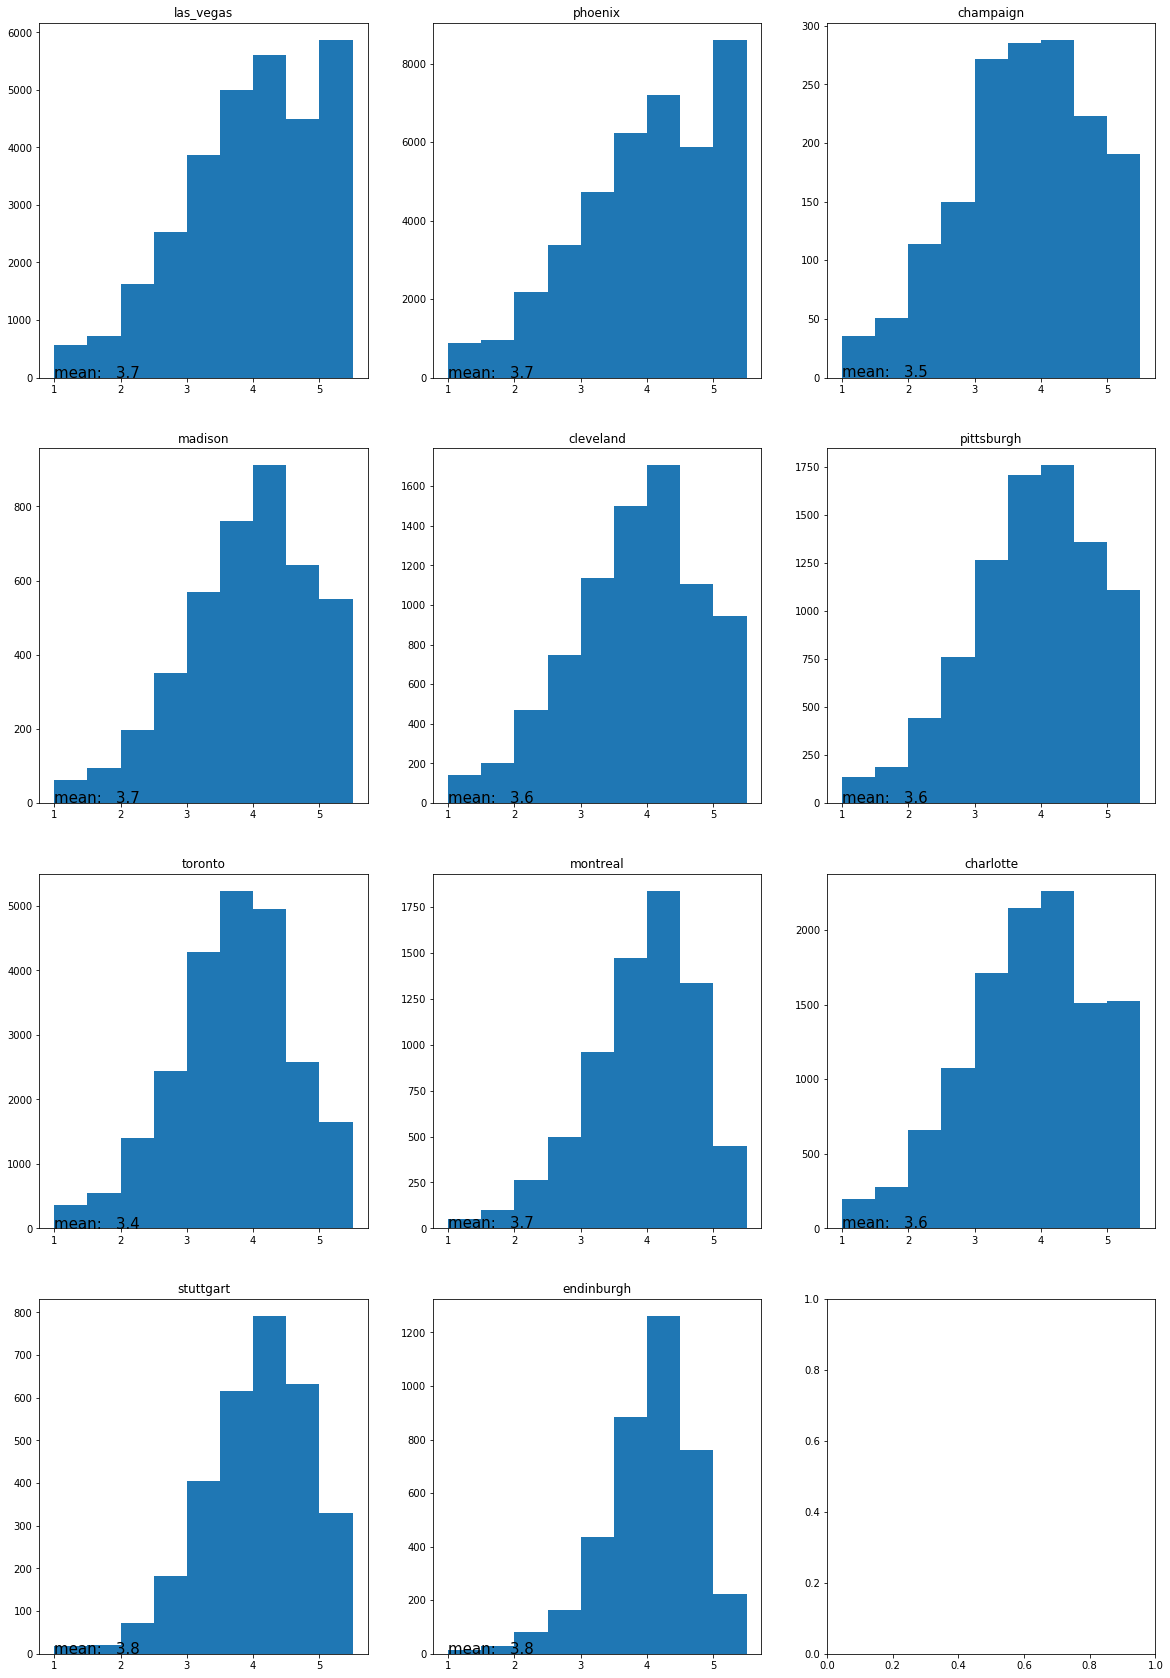

In [143]:
nrow = 4
ncol = 3
fig, axs = plt.subplots(nrow, ncol,figsize=(20, 30))
for ax, city in zip(fig.axes, city_lat_long_dict.keys()):
    stars_data = merged_cities[merged_cities.city_group == city].stars
    ax.hist(stars_data, bins=[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5])
    ax.text(x=1,y=.5, s='mean: {0:5.2}'.format(stars_data.mean()), fontsize=15)
    ax.set_title(city)